This notebook, for now, is best seen as a working, concrete illustration of how these concepts look in python, to supplement other resources that explain the concepts more effectively.

The most important resource I used to build the code here was [Simple Neural Net Backward Pass](https://nasheqlbrm.github.io/blog/posts/2021-11-13-backward-pass.html) (which covers everything but gradients for Cross Entropy Loss and softmax).

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor
from urllib.request import urlretrieve

In [2]:
mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'

In [3]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

if not path_gz.exists():
    urlretrieve(MNIST_URL, path_gz)

In [4]:
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [5]:
TRAIN_SIZE=x_train.shape[0]
BATCH_SIZE=10000
LEARNING_RATE = 0.1

In [6]:
def init_params(size):
    '''
    Xavier Weight Initialization
    strategy for initializing values of weights meant to prevent gradient vanishing or explosion.
    '''
    bound = math.sqrt(1.0 / size[0])
    return torch.randn(size).uniform_(-bound, bound)

'''
implementation below does not use LogSumExp trick to ensure numerical stability.
'''
def softmax(x):
    e=x.exp()
    return e / e.sum(-1,keepdim=True)

def CrossEntropyLoss(p,y):
    losst = -(p[range(p.shape[0]),y].log())
    result = losst.mean()
    return result

In [7]:
weights1 = init_params((784, 200)) # 
bias1    = init_params((200, ))

weights2 = init_params((200, 10))
bias2    = init_params((10,))

We will start by working through individual cells to build up a single pass up prediction and backpropagation before we even try to put any of it into functions. Our batch_size will be 7, so we expect to see that number (along with the dimensions of various parameter tensors, like the number of features for input, hidden, and output layers) in lots of "intermediate" gradient dimensions.

In [8]:
bs=7

x=x_train[0:bs]
y=y_train[0:bs]

# For each feature of the hidden layer, sum the products of each input feature with a corresponding weight and add a bias
z1 = (x @ weights1 + bias1)

# This is relu aka rectified linear unit activation
a1 = z1.max(tensor(0.0))

z2 = (a1 @ weights2 + bias2)

preds = softmax(z2)

L = CrossEntropyLoss(preds, y)

L

tensor(2.32)

batch size = 7
out features = 10
hidden features = 1000
in features = 784

we want:

dL/dweights1, size=(784, 1000)

  = dL/dsoftmax * dsoftmax/dz2 * dz2/da1 * da1/dz1 * dz1/dweights1

dL/dbias1, size = (1000,)

  = dL/dsoftmax * dsoftmax/dz2 * dz2/da1 * da1/dz1 * dz1/dbias1
  
dL/dweights2, size=(1000, 10)

  = dL/dsoftmax * dsoftmax/dz2 * dz2/dweights2
  
dL/dbias2, size=(10)

  = dL/dsoftmax * dsoftmax/dz2 * dz2/dbias2

For a given example from a batch, if p is the prediction of the actual value according to the label, then dL/dsoftmax is:
$$
    (\frac{-1}{Np})
$$
Note that because softmax values other than the argmax don't affect the loss for that example, they zero out

The following code works out a matrix dL/dsoftmax over all the examples and softmax values in the batch

In [10]:
dL_dsoft = torch.zeros((7,10))
dL_dsoft[range(y.shape[0]), y] = -1.0/(preds.shape[0] * preds[range(y.shape[0]), y])
dL_dsoft

tensor([[ 0.00,  0.00,  0.00,  0.00,  0.00, -1.42,  0.00,  0.00,  0.00,  0.00],
        [-1.36,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00, -1.36,  0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00, -1.49,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00, -1.29],
        [ 0.00,  0.00, -1.62,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00, -1.64,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00]])

dsoft/dz with be a matrix size (out_features, out_features) or (10, 10) because there are 10 output activations, and each of them has an influence on each of the 10 softmax outputs.

for a given training example, the $i$th softmax is:
$$
\frac{e^{z_i}}{e^{z_0} + e^{z_1} + \cdots + e^{z_{10}}}
$$

in other words
$$
\frac{e^{z_i}}{\sum_{j=0}^{d} e^{z_j}}
$$
Letting d=out_features, the derivative of the $k$th softmax with regard to ${z_i}$, if $i {\ne} k$, is:
$$
e^{z_i} e^{z_k} \frac{-1}{(\sum_{j=0}^{d} e^{z_j})^2}
$$

except if i=k then there is an additional term added (the numerator is not a constant but a function and hence the product rule must be used). That makes the derivative of the $i$th softmax with regard to the $z_i$ look like this:
$$
e^{2z_i} \frac{-1}{(\sum_{j=0}^{d} e^{z_j})^2} + e^{z_i} \frac{1}{\sum_{j=0}^{d} e^{z_j}}
$$

For a given training example, letting rows indicate z values (differentiated variables) and columns indicate softmax values for which the derivative is being computed, dsoft/dz will be a matrix whose values are the first equation everywhere except the diagonals and the second equation along the diagonals.

Lets, for convenience, make a vector of e raised to the power of every z, and make it a column vector by appending a unit-dimension.

In [11]:
z2exp = z2.exp()[...,None]
z2exp.shape

torch.Size([7, 10, 1])

Computing the full matrix of dlsoft/dz (in other words, for each softmax output, derivative with regard to each $z_i$ which contributed to it) is not necessary since most of them get zeroed out when calculating the gradients we actually want: dL/dsoft is 0 for all but one softmax output in a given example. However we'll just calculate the whole matrix even though most of the columns in a given example will get ignored.

In [12]:
m = z2exp @ torch.einsum('abc->acb', z2exp)
m.shape

torch.Size([7, 10, 10])

In [13]:
expsum = z2exp.sum(dim=1, keepdim=True)
expsum.shape

torch.Size([7, 1, 1])

In [14]:
m = m * (-1. / expsum.pow(2))
m.shape

torch.Size([7, 10, 10])

Compute the additional term to be added onto the diagonals to complete the matrix of gradients while getting rid of the last unit dimension.

In [15]:
diagonal_term = (1.0/expsum)*z2exp
diagonal_term=diagonal_term[...,0]
diagonal_term.shape

torch.Size([7, 10])

In [16]:
m[:,range(z2.shape[1]),range(z2.shape[1])] += diagonal_term

In [17]:
dsoft_dz2 = m

Having now dL/dsoft and dsoft/dz we can compute dL/dz

The mutivariate chain rule says that if we have a function combining other functions of x, like $f(g_1(x), g_2(x), \ldots, g_n(x))$, then the derivative of f with regard to x will be the dot product of the vector of derivatives $\frac{df}{dg_i}$ (for i in $0 \ldots n$) and $\frac{dg_i}{dx}$. We use matrix multiplication to get the dot products of (a) the derivative of Loss with regard to each softmax output for each example, and (b) the derivative of each softmax of an example with regard to a particular $z_i$. Each of those dot products will correspond to a $\frac{dL}{dz_i}$ and each example will produce a vector, the gradients for z. Hence over all examples it will be a matrix of size (batch_size x out_features). And of course, we add and remove a unit dimension in order to properly align the dimensions we're trying to dot-product and then remove the extra that we added afterward.

In [18]:
dL_dsoft.shape,dsoft_dz2.shape
dL_dz2=(dL_dsoft[:,None,:] @ dsoft_dz2)[:,0,:]
dL_dz2.shape

torch.Size([7, 10])

The partial derivative of output with regard to a weight is just the sum over each input which got multiplied by that weight during matrix multiplication. The "inputs" are just "constant multiples" when the weights are viewed as the variable being differentiated against.

In [19]:
dL_dweights2 = a1.t() @ dL_dz2
dL_dweights2.shape

torch.Size([200, 10])

Each bias parameter contributes to only one $z$ output and because it's just added onto a bunch of previous multiplication of weights and inputs, $\frac{dz_i}{db_i}$ is always 1. So the vector of such partial derivatives is a vector of all ones. Hence, and in combination with the "multivariable chain rules are dot products" principle above, $\frac{dL}{db_i}$ is just the sum of $\frac{dL}{dz_i}$ summed over the training examples for which $z_i$ was calculated (that's what you get when you dot product a vector against a vector of ones).

In [20]:
dL_dbias2 = dL_dz2.sum(0)
dL_dbias2.shape

torch.Size([10])

Now find the gradient for the input of the second linear layer. The partial of an output value for any given input is just a sum of weights, which are constant coefficients in this perspective, so we line up the output gradient with the weights which comprise the corresponding partials.

In [21]:
dL_da1 = dL_dz2 @ weights2.t()
dL_da1.shape

torch.Size([7, 200])

a1 came out of a relu, so it's value is just the corresponding z1 (if greater than 0) or 0 elsewise. In the former case, the partial is 1, in the latter, you're finding the derivative of a constant so it's 0. Therefore  $\frac{da1}{dz_1}$ is a vector of 0s and 1s = ($z_i$ > 0).

In [22]:
da1_dz1 = (z1 > 0).float()
da1_dz1.shape

torch.Size([7, 200])

In [23]:
dL_dz1 = dL_da1 * da1_dz1
dL_dz1.shape

torch.Size([7, 200])

Now we repeat the steps above for finding gradients for weights and biases of a linear layer, given the gradient of the output:

In [24]:
x.shape,weights1.shape,dL_dz1.shape

(torch.Size([7, 784]), torch.Size([784, 200]), torch.Size([7, 200]))

In [25]:
dL_dweights1 = x.t() @ dL_dz1
dL_dweights1.shape

torch.Size([784, 200])

In [26]:
dL_dbias1 = dL_dz1.sum(0)
dL_dbias1.shape

torch.Size([200])

Well that's it. Now update parameters.

In [27]:
weights1 -= LEARNING_RATE * dL_dweights1
weights2 -= LEARNING_RATE * dL_dweights2
bias1 -= LEARNING_RATE * dL_dbias1
bias2 -= LEARNING_RATE * dL_dbias2

Now in order to do training over batches and epochs, we'll combine all that huge cludgy code into one function that will:
- make prediction
- calculate loss
- backpropagate the gradients of loss to parameters
- return both predictions and loss

Then we'll loop over that function to train.

In [28]:
class HomebrewModel:
    def __init__(self):
        '''
        784: number of input features (pixels in 28x28 image)
        200: number of feaures in the hidden layer (can be arbitrarily chosen)
        '''
        self.weights1 = init_params((784, 1000)) # 
        self.bias1    = init_params((1000, ))
        '''
        200: match the output coming from features of hidden layer
        10: 10 possible output classifications (corresponding to the digits 0-9)
        '''
        self.weights2 = init_params((1000, 10))
        self.bias2    = init_params((10,))
        
    '''
    Sets gradients on parameters before returning
    
    return (predictions,loss)
    '''
    def predict_and_backpropagate(self, x, y):
        z1 = (x @ self.weights1 + self.bias1)
        a1 = z1.max(tensor(0.0))
        z2 = (a1 @ self.weights2 + self.bias2)
        preds = softmax(z2)
        L = CrossEntropyLoss(preds, y)

        dL_dsoft = torch.zeros(preds.shape)
        dL_dsoft[range(y.shape[0]), y] = -1.0/(preds.shape[0] * preds[range(y.shape[0]), y])
        z2exp = z2.exp()[...,None]
        m = z2exp @ torch.einsum('abc->acb', z2exp)
        expsum = z2exp.sum(dim=1, keepdim=True)
        m = m * (-1. / expsum.pow(2))
        diagonal_term = (1.0/expsum)*z2exp
        diagonal_term = diagonal_term.squeeze()
        m[:,range(z2.shape[1]),range(z2.shape[1])] += diagonal_term

        dsoft_dz2 = m
        dL_dz2=(dL_dsoft[:,None,:] @ dsoft_dz2)[:,0,:]
        dL_dweights2 = a1.t() @ dL_dz2
        dL_dbias2 = dL_dz2.sum(0)
        dL_da1 = dL_dz2 @ self.weights2.t()
        da1_dz1 = (z1 > 0).float()
        dL_dz1 = dL_da1 * da1_dz1
        dL_dweights1 = x.t() @ dL_dz1
        dL_dbias1 = dL_dz1.sum(0)

        self.weights1.diy_grad = dL_dweights1
        self.weights2.diy_grad = dL_dweights2
        self.bias1.diy_grad = dL_dbias1
        self.bias2.diy_grad = dL_dbias2   
        
        return preds,L
    
    '''
    some code duplication of above function, in order to be able to make predictions on validation set without calculating loss
    '''
    def predict(self, x):
        z1 = (x @ self.weights1 + self.bias1)
        a1 = z1.max(tensor(0.0))
        z2 = (a1 @ self.weights2 + self.bias2)
        preds = softmax(z2)
        return preds
   
    def parameters(self):
        return [self.weights1, self.bias1, self.weights2, self.bias2]

In [29]:
'''
epoch goes through entire training set
'''
def train_epoch(model):
    rand_indexes=torch.randperm(TRAIN_SIZE)
    '''
    each batch is a random subset of the training set, loop over batches to cover all training data
    '''
    for i in range(0, TRAIN_SIZE, BATCH_SIZE):
        # pull the random batch
        idxs = rand_indexes[i : i + BATCH_SIZE]
        xb = x_train[idxs]
        yb = y_train[idxs]
        train_batch(model, xb, yb)

                
    # at the end of epoch, check model performance against validation data
    with torch.no_grad():
        valid_preds = model.predict(x_valid)
        validation_acc = batch_accuracy(valid_preds, y_valid)
        validation_loss = CrossEntropyLoss(valid_preds, y_valid)
        print(f'valid/acc: {validation_acc}\t valid/loss: {validation_loss}')

def train_batch(model, xb, yb):
    preds,loss = model.predict_and_backpropagate(xb, yb)

    with torch.no_grad():
        # update parameters to descend the gradient
        for p in model.parameters():
            p -= LEARNING_RATE * p.diy_grad
            p.diy_grad = None
    
def batch_accuracy(preds_b, yb):
    correct = (preds_b.argmax(1)) == yb
    return correct.float().mean()

In [30]:
model = HomebrewModel()
for epoch in range(10):
    train_epoch(model)

valid/acc: 0.4099999964237213	 valid/loss: 2.160120725631714
valid/acc: 0.6890000104904175	 valid/loss: 2.0003321170806885
valid/acc: 0.7451000213623047	 valid/loss: 1.8268029689788818
valid/acc: 0.7685999870300293	 valid/loss: 1.6401201486587524
valid/acc: 0.7850000262260437	 valid/loss: 1.4530173540115356
valid/acc: 0.8044000267982483	 valid/loss: 1.2808550596237183
valid/acc: 0.820900022983551	 valid/loss: 1.1328946352005005
valid/acc: 0.8338000178337097	 valid/loss: 1.0113409757614136
valid/acc: 0.8424000144004822	 valid/loss: 0.9131684303283691
valid/acc: 0.8482999801635742	 valid/loss: 0.83420330286026


Now to clean this up a substantial degree, we'll refactor each layer of computation into an object that computes it's own gradient when called upon.

# Pick a random number and try
Run cell below to pick a random number from the training set, see it, and see the prediction made for it

Prediction: 3
Confidence: 19.2%
Label: 5


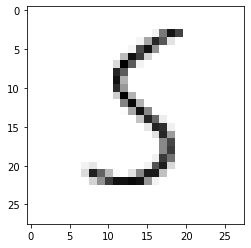

In [43]:
idx = torch.randint(0,TRAIN_SIZE-1, (1,)).item()
preds = model.predict(x_train[idx])
prediction = preds.argmax()
confidence = preds[prediction]
print(f'Prediction: {prediction}\nConfidence: {confidence:.1%}\nLabel: {y_train[idx]}')
plt.imshow(x_train[idx].view(28, 28) * -1.0)